I generate a set of supernova data, with measurements of the redshift $z$ and of the distance module $\mu = m-M =  5 \log_{10}\left(\frac{d_L}{\rm pc}\right) - 5$. I perform regression with different methods:
- Linear regression
- Polynomial regression (I use cross-validation to find the best order and I analyze the learning curves)
- Basis function regression
- Kernel regression

In [28]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import os
import scipy.optimize as opt
import scipy.stats as st
import sklearn.manifold
import sklearn.model_selection

**Generation of the dataset**

<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
C:\Users\marti\AppData\Local\Temp\ipykernel_11304\3381167969.py:7: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mu$")


(35.0, 50.0)

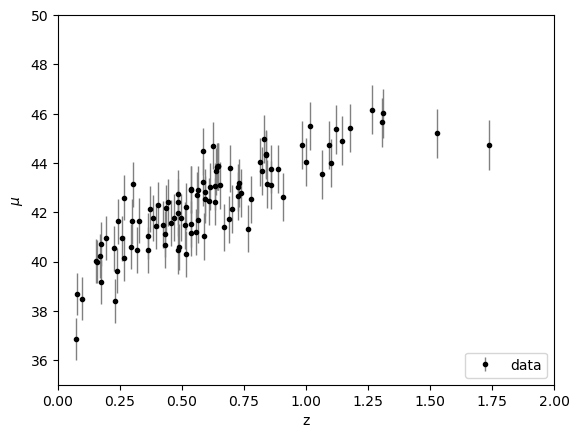

In [29]:
from astroML.datasets import generate_mu_z
# generate_mu_z generates a dataset of distance modulus vs redshift.
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234) # YOU CANNOT CHANGE THIS

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

# Part 1

**Linear regression**

In [30]:
X = z_sample[:,np.newaxis]
y = mu_sample

Intercept =  39.604564811058694 , Coef =  4.5911933045002575


<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
C:\Users\marti\AppData\Local\Temp\ipykernel_11304\3513907876.py:17: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mu$")


Text(0.5, 1.0, 'Linear regression')

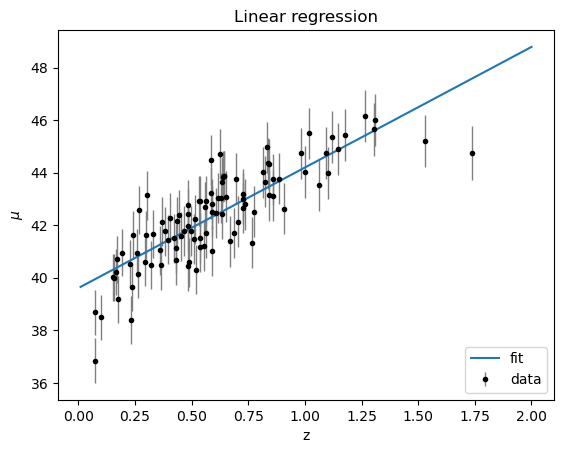

In [31]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y, dmu)

theta0 = lin_reg.intercept_
theta1 = lin_reg.coef_
z = np.linspace(0.01, 2, 1000)
z = z[:,np.newaxis]

print("Intercept = ", theta0, ", Coef = ", theta1[0])
y_pred = lin_reg.predict(z)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(z, y_pred, '-', label = 'fit')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.title('Linear regression')

**Polynomial regression**

<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
C:\Users\marti\AppData\Local\Temp\ipykernel_11304\2806774516.py:16: SyntaxWarning: invalid escape sequence '\m'
  ax[i].set_ylabel("$\mu$")


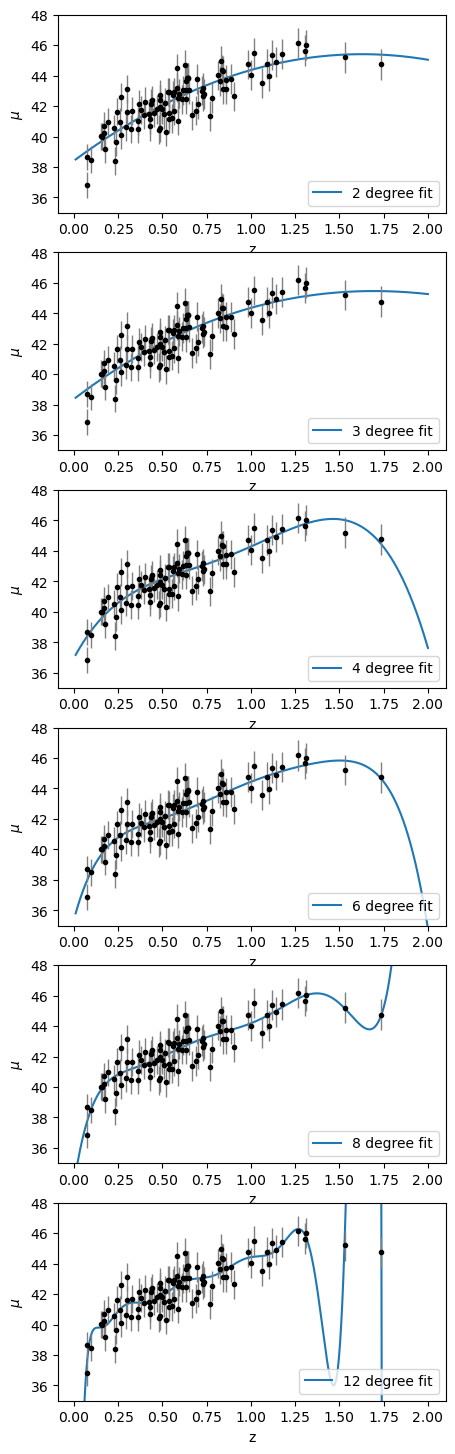

In [32]:
from astroML.linear_model import PolynomialRegression

degree = [2, 3, 4, 6, 8, 12]
coefficients = []

# plots
fig, ax = plt.subplots(len(degree), 1, figsize=(5,18))
i=0

for n in degree:
   model = PolynomialRegression(n) # fit n degree polynomial
   model.fit(X, y, dmu)
   y_pred = model.predict(z)
   ax[i].plot(z, y_pred, '-', label = '%i degree fit' %n)
   ax[i].set_xlabel("z")
   ax[i].set_ylabel("$\mu$")
   ax[i].legend(loc='lower right')
   ax[i].set_ylim(35, 48)
   ax[i].errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
   coefficients.append(model.coef_)
   i=i+1

plt.show()

Observing the plots, I can conclude that if I use a linear fit I am underfitting the data, while if I use a high degree polynomial I am overfitting the data (look at the 8 and 12 degree fit). I ipotize that the best fits are the ones characterized by 2nd and 3rd degree polynomials.
I use cross validation to confirm what I am expecting.

**Cross validation**

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

# train-test split
ydy = np.zeros((len(y), 2))  # I create an array that contains both y and the errors
for i in range (len(y)):
    ydy[i][0] = y[i]
    ydy[i][1] = dmu[i]

X_train, X_validation, ydy_train, ydy_validation = train_test_split(X, ydy, test_size=0.25)

# y values:
y_train = ydy_train[:,0]
y_validation = ydy_validation[:,0]
# error values:
dy_train = ydy_train[:,1]
dy_validation = ydy_validation[:,1]

degree = np.arange(2, 16)
error_train = np.zeros(len(degree))
error_validation = np.zeros(len(degree))
j=0
for n in degree:
   model = PolynomialRegression(n) # fit n degree polynomial
   model.fit(X_train, y_train, dy_train)
   y_train_pred = model.predict(X_train)
   y_validation_pred = model.predict(X_validation)

   error_train[j] = np.sqrt(np.sum((y_train-y_train_pred)**2)/len(X_train))
   error_validation[j] = np.sqrt(np.sum((y_validation-y_validation_pred)**2)/len(X_validation))

   print('Polynomial regression degree %i' %n)
   print('Error train = %.2f' %error_train[j])
   print('Error validation = %.2f' %error_validation[j])
   print('--------------------------------------------')
   j=j+1

print('The best model is the %i degree polynomial' %degree[np.argmin(error_validation)])

Polynomial regression degree 2
Error train = 0.91
Error validation = 0.89
--------------------------------------------
Polynomial regression degree 3
Error train = 0.91
Error validation = 0.89
--------------------------------------------
Polynomial regression degree 4
Error train = 0.88
Error validation = 0.87
--------------------------------------------
Polynomial regression degree 5
Error train = 0.87
Error validation = 0.86
--------------------------------------------
Polynomial regression degree 6
Error train = 0.87
Error validation = 0.86
--------------------------------------------
Polynomial regression degree 7
Error train = 0.84
Error validation = 0.92
--------------------------------------------
Polynomial regression degree 8
Error train = 0.84
Error validation = 0.92
--------------------------------------------
Polynomial regression degree 9
Error train = 0.84
Error validation = 0.92
--------------------------------------------
Polynomial regression degree 10
Error train = 0.

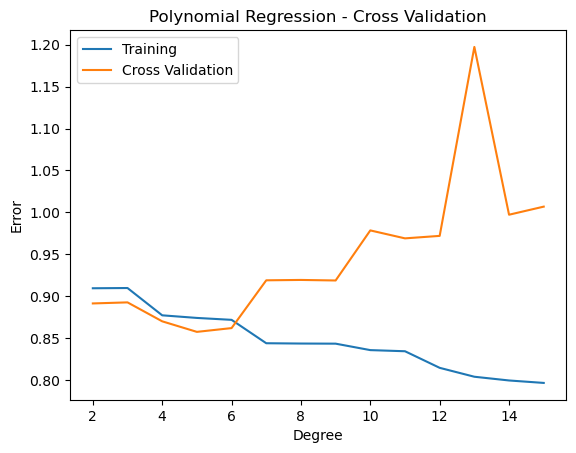

In [34]:
# I plot the results of cross-validation
plt.plot(degree, error_train, label='Training')
plt.plot(degree, error_validation, label='Cross Validation')
plt.xlabel('Degree')
plt.ylabel('Error')
plt.legend()
plt.title('Polynomial Regression - Cross Validation')
plt.show()

I can conclude that if I use a polynomial with degree > 6 I am overfitting the data.

Once I confirmed that a polynomial with a low degree is the best fit, I can analyze the learning curves.

# Part 2

**Learning Curves**

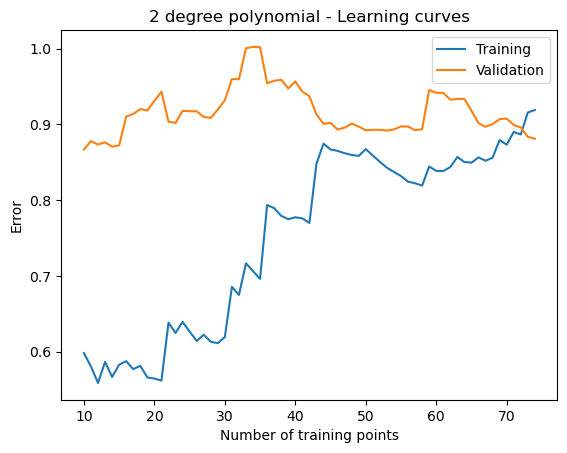

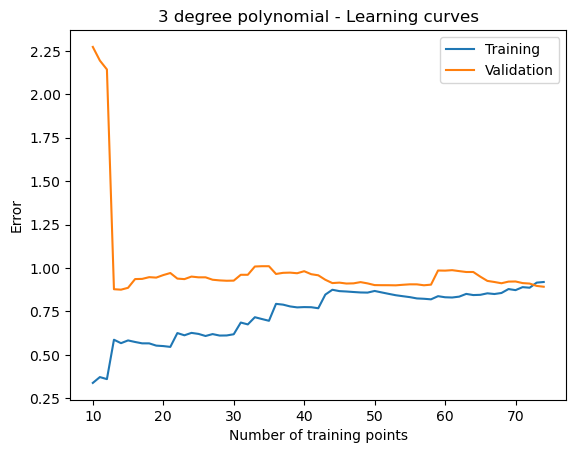

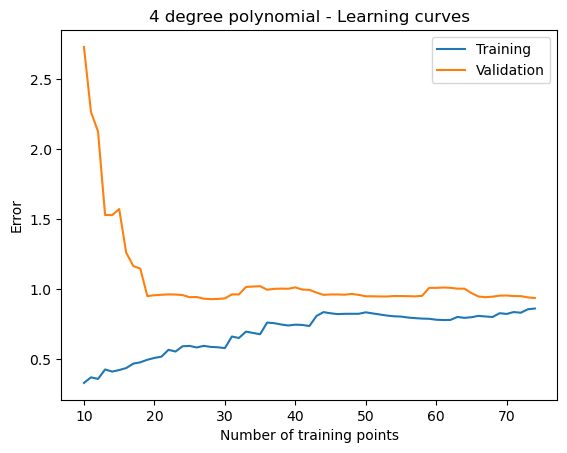

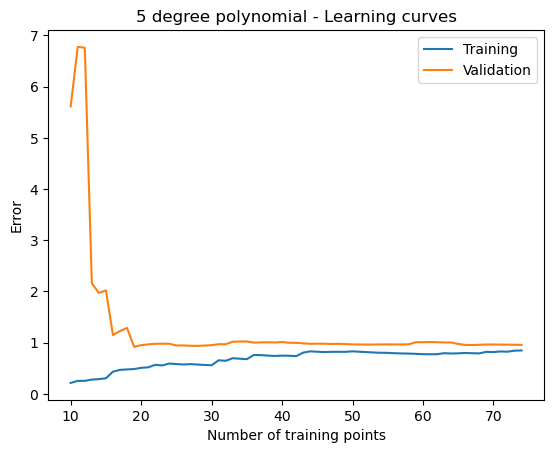

In [36]:
# train-test split
ydy = np.zeros((len(y), 2))  # I create an array that contains both y and the errors
for i in range (len(y)):
    ydy[i][0] = y[i]
    ydy[i][1] = dmu[i]

X_train, X_validation, ydy_train, ydy_validation = train_test_split(X, ydy, test_size=0.25)

# y values:
y_train = ydy_train[:,0]
y_validation = ydy_validation[:,0]
# error values:
dy_train = ydy_train[:,1]
dy_validation = ydy_validation[:,1]

degree = [2, 3, 4, 5]
n_dataset = np.arange(10, len(X_train))

for d in degree:
  error_train = np.zeros(len(n_dataset))
  error_validation = np.zeros(len(n_dataset))
  j=0

  for N in n_dataset:
    X_train_N = X_train[:N]
    y_train_N = y_train[:N]
    dy_train_N = dy_train[:N]

    model = PolynomialRegression(d) # fit d degree polynomial
    model.fit(X_train_N, y_train_N, dy_train_N)
    y_train_pred = model.predict(X_train_N)
    y_validation_pred = model.predict(X_validation)

    error_train[j] = np.sqrt(np.sum((y_train_N-y_train_pred)**2)/len(X_train_N))
    error_validation[j] = np.sqrt(np.sum((y_validation-y_validation_pred)**2)/len(X_validation))
    j=j+1

  # I plot the Learning Curves
  plt.plot(n_dataset, error_train, label='Training')
  plt.plot(n_dataset, error_validation, label='Validation')
  plt.xlabel('Number of training points')
  plt.ylabel('Error')
  plt.legend()
  plt.title('%i degree polynomial - Learning curves' %d)
  plt.show()


In addition to polynomial regression, I can also perform Basis function Regression and Kernel Regression.

**Basis function regression**

<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
C:\Users\marti\AppData\Local\Temp\ipykernel_11304\1148333789.py:18: SyntaxWarning: invalid escape sequence '\m'
  ax[i].set_ylabel("$\mu$")


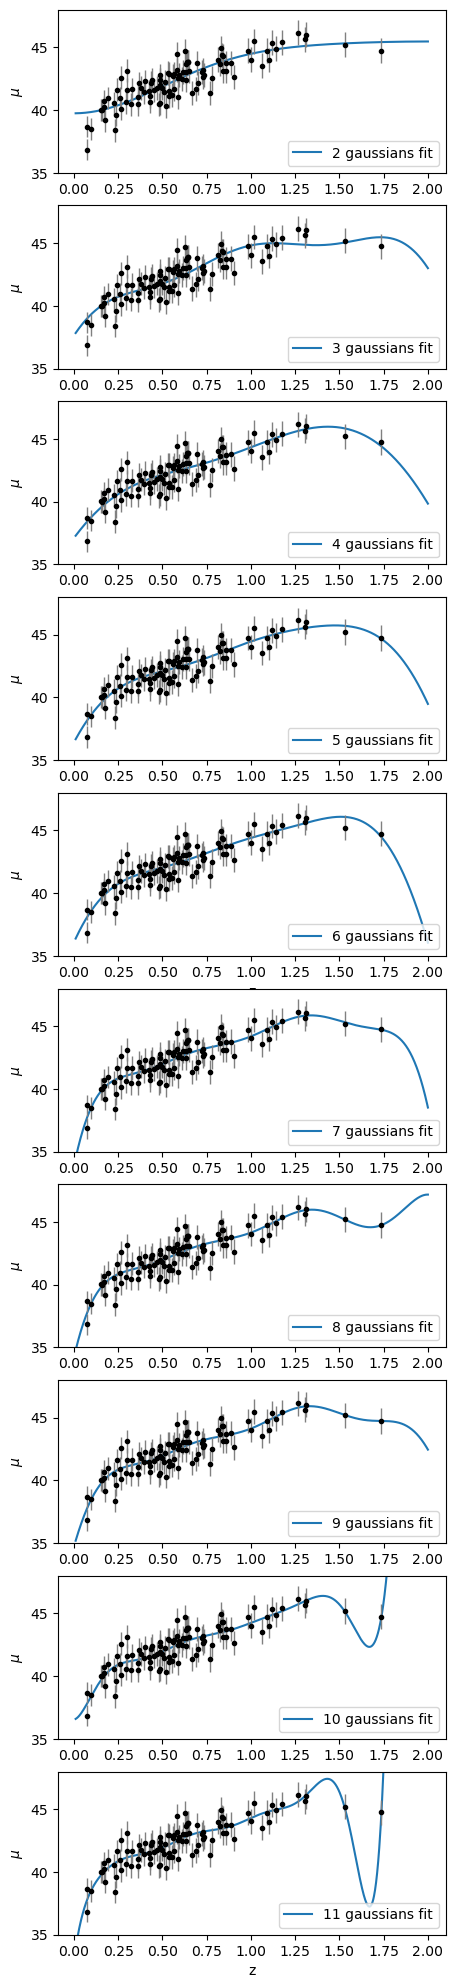

In [37]:
from astroML.linear_model import BasisFunctionRegression

n_gaussian = np.arange(2, 12)
sigma_fix = 0.5  # I fix the sigma of the gaussians

# plots
fig, ax = plt.subplots(len(n_gaussian), 1, figsize=(5,25))
i=0

for n in n_gaussian:
   centers_points = np.linspace(0, 2.0, n)     # I want n gaussians -> centering them in a linspace of n points
   centers = centers_points[:, np.newaxis]
   model = BasisFunctionRegression('gaussian', mu=centers, sigma=sigma_fix) # fit n gaussians
   model.fit(X, y, dmu)
   y_pred = model.predict(z)
   ax[i].plot(z, y_pred, '-', label = '%i gaussians fit' %n)
   ax[i].set_xlabel("z")
   ax[i].set_ylabel("$\mu$")
   ax[i].legend(loc='lower right')
   ax[i].set_ylim(35, 48)
   ax[i].errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
   i=i+1

plt.show()

**Kernel Regression**

<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
C:\Users\marti\AppData\Local\Temp\ipykernel_11304\3425480966.py:15: SyntaxWarning: invalid escape sequence '\m'
  ax[i].set_ylabel("$\mu$")


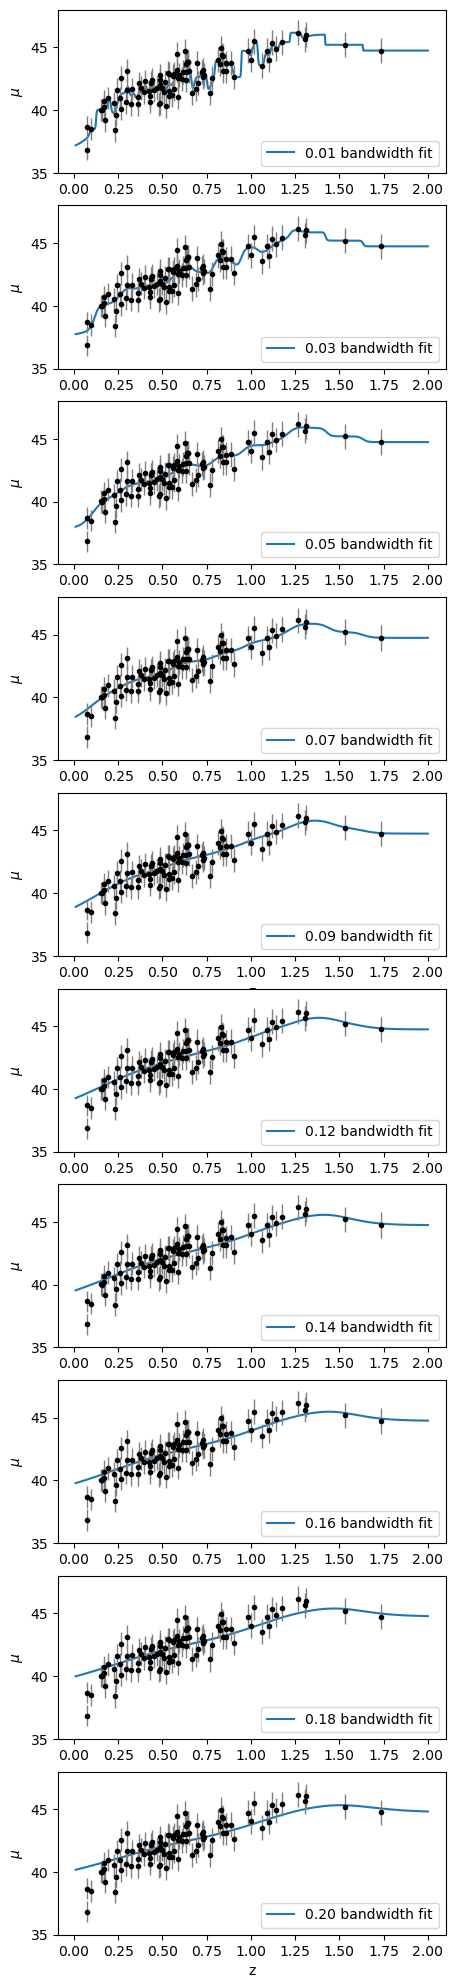

In [38]:
from astroML.linear_model import NadarayaWatson

bandwidth = np.linspace(0.01, 0.2, 10)

# plots
fig, ax = plt.subplots(len(bandwidth), 1, figsize=(5,25))
i=0

for b in bandwidth:
   model = NadarayaWatson(kernel='gaussian', h=b)
   model.fit(X, y, dmu)
   y_pred = model.predict(z)
   ax[i].plot(z, y_pred, '-', label = '%.2f bandwidth fit' %b)
   ax[i].set_xlabel("z")
   ax[i].set_ylabel("$\mu$")
   ax[i].legend(loc='lower right')
   ax[i].set_ylim(35, 48)
   ax[i].errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
   i=i+1

plt.show()